# Préparation & preprocessing

In [3]:
# ---
# 1) Préparation : on charge les données et on prépare les features
# Objectif : prédire "YearsAtCompany" (ancienneté dans l'entreprise).
# ---

import os, urllib.request, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Dataset
CSV_NAME = "WA_Fn-UseC_-HR-Employee-Attrition.csv"

# Chargement + ménage léger
df = pd.read_csv(CSV_NAME).copy()
drop_cols = [c for c in ["EmployeeCount","Over18","StandardHours","EmployeeNumber"] if c in df.columns]
df = df.drop(columns=drop_cols)

# Cible = YearsAtCompany
assert "YearsAtCompany" in df.columns, "YearsAtCompany manquant."
y = df["YearsAtCompany"].values
X = df.drop(columns=["YearsAtCompany"])

# Colonnes catégorielles / numériques
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

# Préprocesseur simple : OneHot + StandardScaler
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # compat anciennes versions

prepro = ColumnTransformer([
    ("cat", ohe, cat_cols),
    ("num", StandardScaler(), num_cols)
])

print(f"X: {X.shape}, y mean={y.mean():.1f}")

X: (1470, 30), y mean=7.0


# Cross-Validation : comparaison des modèles

In [4]:
# ---
# 2) On compare 3 modèles : LinReg, Arbre, Random Forest
# On utilise des prédictions hors-pli (CV OOF) pour éviter le surapprentissage.
# KPI = MAE, R², MAPE.
# ---

from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def mape_safe(y_true, y_pred, eps=1e-9):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    mask = np.abs(y_true) > eps
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))) if mask.sum() else np.nan

np.random.seed(42)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LinReg": LinearRegression(),
    "Tree":   DecisionTreeRegressor(random_state=42),
    "RF":     RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)
}

rows, oof_preds = [], {}
for name, reg in models.items():
    pipe = Pipeline([("prep", prepro), ("reg", reg)])
    yhat_oof = cross_val_predict(pipe, X, y, cv=cv, n_jobs=-1, method="predict")
    oof_preds[name] = yhat_oof

    mae  = mean_absolute_error(y, yhat_oof)
    r2   = r2_score(y, yhat_oof)
    mape = mape_safe(y, yhat_oof) * 100

    rows.append({"Model": name, "MAE": round(mae,2), "R²": round(r2,3), "MAPE (%)": round(mape,2)})

scores = pd.DataFrame(rows).sort_values("MAE").reset_index(drop=True)
scores

,Model,MAE,R²,MAPE (%)
0,RF,0.85,0.925,14.29
1,Tree,1.06,0.828,17.63
2,LinReg,1.95,0.763,43.08


# Choix du meilleur modèle + scatter y vs ŷ

✅ Modèle retenu (CV): RF


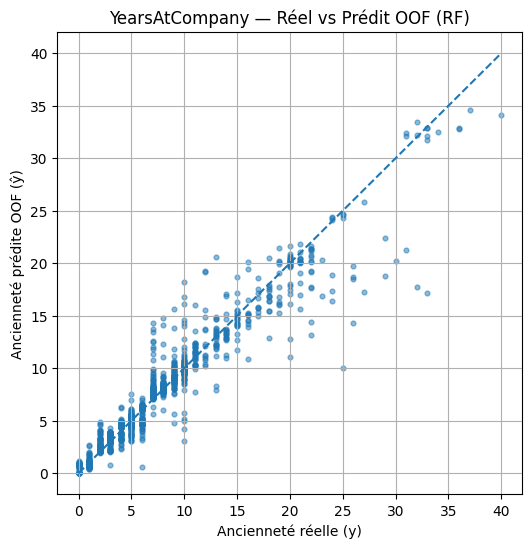

In [5]:
# ---
# 3) On garde le meilleur modèle (souvent RF).
# On trace "réel vs prédit (OOF)" → montre si le modèle colle bien aux valeurs.
# ---

best_name = scores.iloc[0]["Model"]
yhat_best = oof_preds[best_name]

print(f"✅ Modèle retenu (CV): {best_name}")

plt.figure(figsize=(6,6))
plt.scatter(y, yhat_best, s=12, alpha=0.5)
minv, maxv = float(min(y.min(), yhat_best.min())), float(max(y.max(), yhat_best.max()))
plt.plot([minv,maxv],[minv,maxv],'--')
plt.xlabel("Ancienneté réelle (y)")
plt.ylabel("Ancienneté prédite OOF (ŷ)")
plt.title(f"YearsAtCompany — Réel vs Prédit OOF ({best_name})")
plt.grid(True)
plt.show()

# Explicabilité SHAP (importance + effet directionnel)

100%|===================| 1467/1470 [01:08<00:00]       

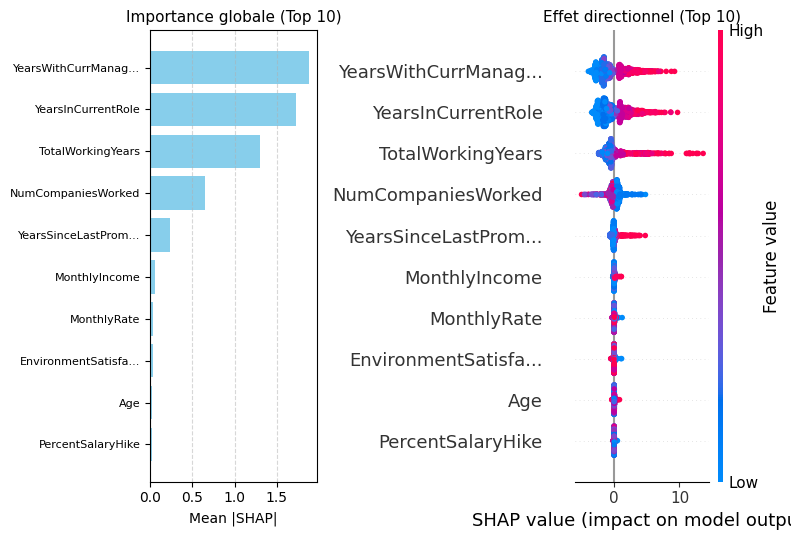

In [21]:
# ---
# SHAP : Importance globale (bar chart inversé) + Effet directionnel (beeswarm)
# Format identique au PDP : 1 ligne, 2 colonnes, figsize=(10,4)
# ---

import numpy as np
import matplotlib.pyplot as plt
import shap

# Refit du meilleur modèle sur tout X,y
best_pipe = Pipeline([("prep", prepro), ("reg", models[best_name])])
best_pipe.fit(X, y)

# Données transformées + noms de colonnes
Xmat = prepro.fit_transform(X)
feat_names = np.array(prepro.get_feature_names_out())

# SHAP Explainer
explainer = shap.Explainer(best_pipe.named_steps["reg"], Xmat, feature_names=feat_names)
shap_values = explainer(Xmat, check_additivity=False)

# Moyenne des |SHAP| → top 10
vals = np.asarray(shap_values.values)
if vals.ndim == 1:
    vals = vals.reshape(-1, 1)

mean_abs = np.abs(vals).mean(axis=0)
top_idx = np.argsort(-mean_abs)[:10]
top_feats = feat_names[top_idx]
top_vals = mean_abs[top_idx]

# Nettoyage noms pour affichage court
def clean_label(name, maxlen=18):
    name = name.replace("cat__", "").replace("num__", "")
    return (name[:maxlen] + "...") if len(name) > maxlen else name

labels = [clean_label(f) for f in top_feats]

# --- Figure (même format que PDP) ---
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# (1) Bar chart inversé à gauche
ypos = np.arange(len(top_feats))
ax[0].barh(ypos, top_vals, color="skyblue")
ax[0].set_yticks(ypos, labels, fontsize=8)
ax[0].invert_yaxis()  # plus important en haut
ax[0].set_xlabel("Mean |SHAP|")
ax[0].set_title("Importance globale (Top 10)", fontsize=11)
ax[0].grid(True, axis="x", linestyle="--", alpha=0.5)

# (2) Beeswarm limité au top 10 à droite
plt.sca(ax[1])  # forcer shap à dessiner sur le subplot de droite
shap.summary_plot(
    shap_values[:, top_idx],
    Xmat[:, top_idx],
    feature_names=[clean_label(f) for f in top_feats],
    max_display=10,
    show=False
)
ax[1].set_title("Effet directionnel (Top 10)", fontsize=11)

plt.tight_layout()
plt.show()

# Courbes de dépendance partielle (PDP) sur 2 variables clés

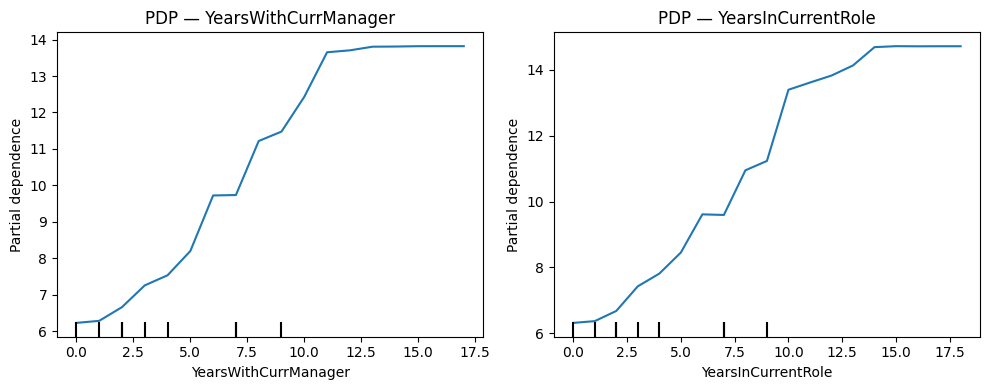

In [14]:
# ---
# PDP robuste : on essaie d'abord les noms bruts, puis on retombe
# sur les noms transformés automatiquement par le ColumnTransformer.
# ---

from sklearn.inspection import PartialDependenceDisplay

# Noms transformés générés par le préprocesseur
feat_names = prepro.get_feature_names_out()

def find_transformed_name(substr: str, feature_names) -> str | None:
    """Retourne le 1er nom transformé qui contient la sous-chaîne (sinon None)."""
    hits = [f for f in feature_names if substr in f]
    return hits[0] if hits else None

targets = ["YearsWithCurrManager", "YearsInCurrentRole"]

fig, ax = plt.subplots(1, len(targets), figsize=(10, 4))
if len(targets) == 1:
    ax = [ax]  # uniformiser

for i, raw_name in enumerate(targets):
    shown = False
    # 1) On tente d'abord le nom brut
    try:
        PartialDependenceDisplay.from_estimator(best_pipe, X, [raw_name], ax=ax[i])
        ax[i].set_title(f"PDP — {raw_name}")
        shown = True
    except Exception:
        pass

    # 2) Sinon on cherche le nom transformé correspondant et on réessaie
    if not shown:
        tf_name = find_transformed_name(raw_name, feat_names)
        if tf_name is not None:
            try:
                PartialDependenceDisplay.from_estimator(best_pipe, X, [tf_name], ax=ax[i])
                ax[i].set_title(f"PDP — {raw_name}")
                shown = True
            except Exception:
                pass

    # 3) Si rien ne marche, on évite de planter et on explique
    if not shown:
        ax[i].axis("off")
        ax[i].set_title(f"{raw_name} introuvable")
        # Astuce debug (facultatif) : décommente pour voir quelques noms possibles
        # print("Exemples de noms dispo :", feat_names[:20])

plt.tight_layout()
plt.show()

# Comparaison avec l’attrition : top variables (bar chart)

 99%|===================| 2922/2940 [02:32<00:00]       

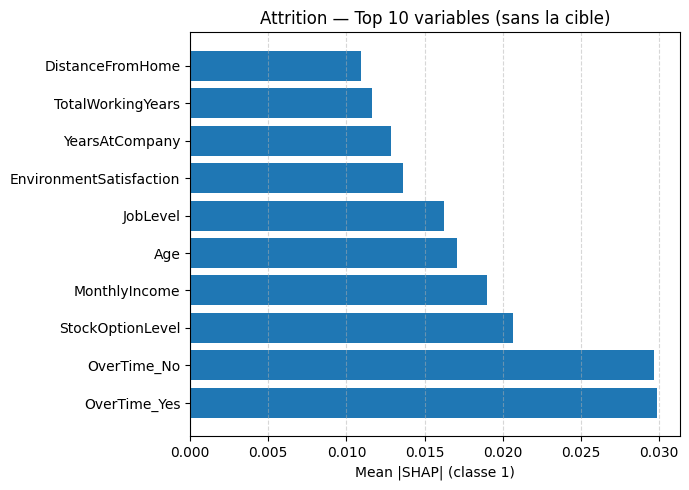

In [22]:
# ---
# 6) ATTRITION (corrigé) — entraînement + SHAP top 10 (barh robuste)
# Objectif : comparer les facteurs de départ (classe 1) SANS utiliser la cible "Attrition" comme feature.
# ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import shap

# 1) Séparer X_attr / y_attr (on enlève la cible des features)
assert "Attrition" in df.columns, "Colonne Attrition introuvable."
y_attr = df["Attrition"].map({"Yes": 1, "No": 0}).values
X_attr = df.drop(columns=["Attrition"]).copy()

# 2) Préprocesseur dédié à X_attr (cat = OHE, num = standardisation)
cat_cols_attr = [c for c in X_attr.columns if X_attr[c].dtype == "object"]
num_cols_attr = [c for c in X_attr.columns if c not in cat_cols_attr]
try:
    ohe_attr = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe_attr = OneHotEncoder(handle_unknown="ignore", sparse=False)

prepro_attr = ColumnTransformer([
    ("cat", ohe_attr, cat_cols_attr),
    ("num", StandardScaler(), num_cols_attr)
])

# 3) Pipeline simple et robuste (RF classifieur équilibré)
pipe_attr = Pipeline([
    ("prep", prepro_attr),
    ("clf", RandomForestClassifier(
        n_estimators=400, class_weight="balanced",
        random_state=42, n_jobs=-1
    ))
])
pipe_attr.fit(X_attr, y_attr)

# 4) Données transformées + noms lisibles
Xmat_attr = prepro_attr.transform(X_attr)
feat_names_attr = list(prepro_attr.get_feature_names_out())

# 5) SHAP (classe 1) → bar chart "maison" pour éviter les bugs d'index
explainer_attr = shap.Explainer(pipe_attr.named_steps["clf"], Xmat_attr, feature_names=feat_names_attr)
exp_attr = explainer_attr(Xmat_attr, check_additivity=False)

def shap_to_2d_values(shap_exp, class_index=1):
    vals = getattr(shap_exp, "values", shap_exp)
    vals = np.asarray(vals)
    if vals.ndim == 3:  # (n_samples, n_features, n_classes)
        vals = vals[:, :, class_index] if vals.shape[-1] > class_index else vals.mean(axis=-1)
    if vals.ndim == 1:
        vals = vals.reshape(-1, 1)
    return vals

vals_2d = shap_to_2d_values(exp_attr, class_index=1)

# Harmonisation longueur noms / features (sécurité)
n_feat = vals_2d.shape[1]
if len(feat_names_attr) != n_feat:
    feat_names_attr = feat_names_attr[:n_feat]

# 6) Top 10 par moyenne des |SHAP|
mean_abs = np.abs(vals_2d).mean(axis=0)
top_idx  = np.argsort(-mean_abs)[:10]
top_feats = [feat_names_attr[i] for i in top_idx]
top_vals  = mean_abs[top_idx]

# 7) Barh lisible (du plus important en haut)
plt.figure(figsize=(7,5))
ypos = np.arange(len(top_feats))[::-1]
labels = [f.replace("cat__", "").replace("num__", "") for f in top_feats[::-1]]
plt.barh(ypos, top_vals[::-1])
plt.yticks(ypos, labels)
plt.xlabel("Mean |SHAP| (classe 1)")
plt.title("Attrition — Top 10 variables (sans la cible)")
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [23]:
# 8) (Optionnel) tableau top 10 pour la slide
top_table = pd.DataFrame({"Feature": top_feats, "Mean |SHAP|": top_vals})
try:
    display(top_table)
except:
    print(top_table)

print("Lecture : ces variables poussent le modèle vers 'départ' (classe 1).")

,Feature,Mean |SHAP|
0,cat__OverTime_Yes,0.029832
1,cat__OverTime_No,0.029665
2,num__StockOptionLevel,0.020648
3,num__MonthlyIncome,0.018982
4,num__Age,0.017071
5,num__JobLevel,0.016261
6,num__EnvironmentSatisfaction,0.013599
7,num__YearsAtCompany,0.012833
8,num__TotalWorkingYears,0.011629
9,num__DistanceFromHome,0.010949


Lecture : ces variables poussent le modèle vers 'départ' (classe 1).
